# Fits negative binomial to each gene/celltype combination & samples to simulate data.
-> Using HVGs+LR genes, sampling simulated cells w/o replacement,
	             10,000 single cells simulated, & simulates the same sparsity
	            between the original single cell data & real data.
	             After simulating scRNA-seq, then samples cells from this & adds
	             together in defined proportions to create Visium spots. The
	             defined proportions change depending on the type of neighbourhood
	             in a defined grid the spots fall within, to simulate
	             colocalisation of cell types. Uses breast scRNA-seq data.

INPUT: 
 * data/sim_data/breast_sc.h5ad

OUTPUT:
 * data/sim_data/spatialsim_v2.h5ad

## Environment Setup

In [88]:
# Change to equivalent working dir #
work_dir = '/Users/uqbbalde/Desktop/Uni_Studies/projects/stLearn/'
import os 
os.chdir(work_dir)

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

import statsmodels.api as sm
from scipy import stats
import scipy.spatial as spatial

from sklearn.cluster import KMeans

import stlearn as st

import warnings
warnings.filterwarnings("ignore")

from PIL import Image

data_dir = 'data/sim_data/'
out_dir = data_dir

## Loading the data

In [2]:
data = sc.read_h5ad(data_dir+'breast_sc.h5ad')
counts = data.raw.to_adata().to_df()
counts = pd.DataFrame(np.round(counts.values), index=counts.index, columns=counts.columns)
labels = data.obs['cell_type'].values.astype(str)

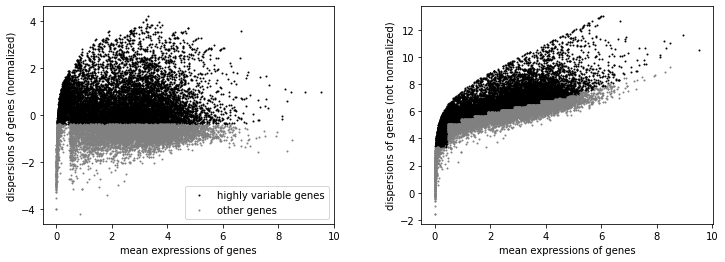

10060


In [11]:
## Calling hvgs ##
sc.pp.highly_variable_genes(data, max_mean=10, min_mean=0, min_disp=-.375)
sc.pl.highly_variable_genes(data)
hvgs = data.var_names.values[data.var['highly_variable']]
print(len(hvgs))

In [12]:
## Getting the LR genes ##
lrs = st.tl.cci.load_lrs()
lr_genes = []
[lr_genes.extend(lr.split('_')) for lr in lrs]
lr_genes = np.unique( [gene for gene in lr_genes if gene in data.var_names] )

sim_genes = np.unique(list(hvgs)+list(lr_genes))
print(len(sim_genes))

10335


In [13]:
print( counts.shape )
# gene_counts = (counts.values>0).sum(axis=0)
# counts = counts.loc[:,gene_counts>40]
counts = counts.loc[:,sim_genes]
print( counts.shape )

(1112, 16837)
(1112, 10335)


## Per cell type, fitting NB distribution

In [14]:
def get_stats(scores: np.array, background: np.array, total_bg: int,
              neg_binom: bool = False, adj_method: str = 'fdr_bh',
              pval_adj_cutoff: float = 0.01, return_negbinom_params: bool=False,
              ):
    """Retrieves valid candidate genes to be used for random gene pairs.
    Parameters
    ----------
    scores: np.array        Per spot scores for a particular LR pair.
    background: np.array    Background distribution for non-zero scores.
    total_bg: int           Total number of background values calculated.
    neg_binom: bool         Whether to use neg-binomial distribution to estimate p-values, NOT appropriate with log1p data, alternative is to use background distribution itself (recommend higher number of n_pairs for this).
    adj_method: str         Parsed to statsmodels.stats.multitest.multipletests for multiple hypothesis testing correction.
    Returns
    -------
    stats: tuple          Per spot pvalues, pvals_adj, log10_pvals_adj, lr_sign (the LR scores for significant spots).
    """
    if neg_binom:
        # Need to make full background for fitting !!!
        background = np.array( list(background)+[0]*(total_bg-len(background)))
        pmin, pmax = min(background), max(background)
        background2 = [item - pmin for item in background]
        x = np.linspace(pmin, pmax, 1000)
        res = sm.NegativeBinomial(
            background2, np.ones(len(background2)), loglike_method="nb2"
        ).fit(start_params=[0.1, 0.3], disp=0)
        mu = res.predict()  # use if not constant
        mu = np.exp(res.params[0])
        alpha = res.params[1]
        Q = 0
        size = 1.0 / alpha * mu ** Q
        prob = size / (size + mu)

        if return_negbinom_params: # For testing purposes #
            return size, prob

In [15]:
nb_params = {}
label_set = np.unique(labels)
genes = counts.columns.values.astype(str)
for i, label in enumerate(label_set):
    label_bool = labels==label
    label_counts = counts.values[label_bool,:]
    nb_params[label] = {}
    for j, gene in enumerate(genes):
        label_gene_counts = label_counts[:,j]
        
        if np.all(label_gene_counts==0):
            nb_params[label][gene] = (0, 0)
            continue
        
        size, prob = get_stats(None, label_gene_counts, len(label_gene_counts),
                              neg_binom=True, return_negbinom_params=True,
                             )
        nb_params[label][gene] = (size, prob)

In [16]:
# Getting zero-proportion of each celltype/gene combination #
gene_zeros = {}
for label in label_set:
    label_bool = labels==label
    n_labels = sum(label_bool)
    gene_zeros[label] = {}
    for gene in genes:
        gene_zeros[label][gene] = len(np.where(counts.loc[label_bool,gene].values==0)[0])/n_labels

In [17]:
gene_zeros

{'Bcell': {'A1BG': 0.9473684210526315,
  'A1CF': 0.9473684210526315,
  'A2M': 0.8947368421052632,
  'A2M-AS1': 1.0,
  'A2ML1': 0.7894736842105263,
  'A2MP1': 1.0,
  'AACSP1': 0.9473684210526315,
  'AADAC': 1.0,
  'AADACL2': 1.0,
  'AADAT': 1.0,
  'AAK1': 0.2631578947368421,
  'AANAT': 1.0,
  'AAR2': 0.8421052631578947,
  'AARD': 0.631578947368421,
  'AARS': 0.8421052631578947,
  'AARS2': 0.3684210526315789,
  'AARSD1': 0.7894736842105263,
  'AASDHPPT': 0.8947368421052632,
  'AASS': 0.42105263157894735,
  'AATF': 0.8421052631578947,
  'ABCA1': 0.9473684210526315,
  'ABCA10': 1.0,
  'ABCA11P': 0.9473684210526315,
  'ABCA12': 1.0,
  'ABCA13': 0.8947368421052632,
  'ABCA17P': 0.9473684210526315,
  'ABCA2': 0.8947368421052632,
  'ABCA4': 1.0,
  'ABCA6': 1.0,
  'ABCA7': 0.7894736842105263,
  'ABCA8': 0.8947368421052632,
  'ABCA9': 0.42105263157894735,
  'ABCB1': 0.9473684210526315,
  'ABCB11': 1.0,
  'ABCB4': 0.9473684210526315,
  'ABCB5': 0.5789473684210527,
  'ABCB6': 0.9473684210526315,
 

## Simulating single cell of each type 

In [18]:
n_cells = 10000  # Simulating 10,000 of each cell
n_cells_per_label = n_cells // len(label_set)
n_cells = n_cells_per_label * len(label_set)
sim_counts = np.zeros((n_cells, counts.shape[1]))
sim_labels = np.array(
    [' ' * max([len(label) for label in label_set])] * n_cells)
cell_i = 0
for i, label in enumerate(label_set):
    sim_labels[cell_i:(cell_i + n_cells_per_label)] = label
    for j, gene in enumerate(genes):
        if gene_zeros[label][gene] == 1:  # No need to simulate counts if not expressed...
            continue

        size, prob = nb_params[label][gene]
        if size != 0 and prob != 0:
            # Adding dropout rate so has the same zero proportion as original data #
            counts_ = stats.nbinom.rvs(size, prob, size=n_cells_per_label)
            n_zeros = int(
                np.round(n_cells_per_label * gene_zeros[label][gene]) - sum(
                    counts_ == 0))  # expected-observed
            if n_zeros > 0:  # Setting value with counts to zero
                setzero_indices = np.random.choice(np.where(counts_ > 0)[0],
                                                   n_zeros, replace=False)
                counts_[setzero_indices] = 0
            if (-n_zeros) / n_cells_per_label > 0.1:  # Setting values if too few zeros
                setcount_indices = np.random.choice(
                    np.where(counts_ == 0)[0],
                    -n_zeros, replace=False)
                count_indices = np.where(counts_ > 0)[0]
                if len(count_indices) == 0:
                    prob_small = prob > .98
                    prob = prob if not prob_small else 0.95
                    more_counts = stats.nbinom.rvs(size, prob,
                                                   size=-n_zeros)
                    if prob_small:
                        indices = np.where(more_counts > 0)[0]
                        indices_zero = np.where(more_counts == 0)[0]
                        new_n_zeros = n_zeros + len(indices)
                        if new_n_zeros < 0:
                            more_counts[indices_zero[0:(-new_n_zeros)]] = \
                                more_counts[
                                    np.random.choice(indices, -new_n_zeros,
                                                     replace=True)]
                else:
                    more_counts = counts_[np.random.choice(count_indices,
                                                           -n_zeros,
                                                           replace=True)]

                counts_[setcount_indices] = more_counts

            # Adding to count matrix #
            sim_counts[cell_i:cell_i + n_cells_per_label, j] = counts_

    cell_i += n_cells_per_label

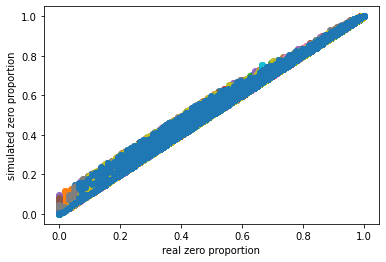

In [19]:
## Checking the zero proportions correct ##
sim_zeros = {}
for label in label_set:
    label_bool = sim_labels==label
    n_labels = sum(label_bool)
    sim_zeros[label] = {}
    for genei, gene in enumerate(genes):
        sim_zeros[label][gene] = len(np.where(sim_counts[label_bool,genei]==0)[0])/n_labels
    
    x, y = np.array(list(gene_zeros[label].values())), np.array(list(sim_zeros[label].values()))
    weird_indices = np.where(np.logical_and(x<.8, y>.9))[0]
    if len(weird_indices)>0:
        print(label, genes[weird_indices], x[weird_indices], y[weird_indices])
    
    bool_ = x<=1
    plt.scatter(x[bool_], y[bool_])
    plt.xlabel('real zero proportion')
    plt.ylabel('simulated zero proportion')

#### Looks great, shows able to get zero proportion very similar!

In [20]:
sim_data = sc.AnnData(pd.DataFrame(sim_counts, columns=counts.columns))
sim_data.obs['cell_type'] = sim_labels

## Running through scanpy workflow

In [21]:
sim_data.raw = sim_data
sc.pp.normalize_total(sim_data)
sc.pp.log1p(sim_data)
sc.tl.pca(sim_data)
sc.pp.neighbors(sim_data)
sc.tl.umap(sim_data)

In [89]:
## Saving the single cell simulated data ##
#sim_data.write_h5ad(out_dir+'sc_sim.h5ad', compression='gzip')
#sim_data = sc.read_h5ad(out_dir+'sc_sim.h5ad')

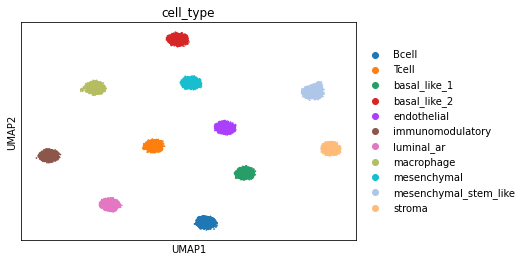

In [24]:
sc.pl.umap(sim_data, color='cell_type')

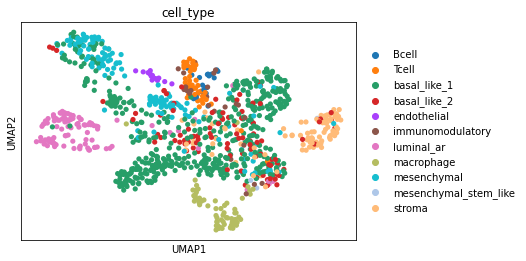

In [25]:
sc.pl.umap(data, color='cell_type')

In [26]:
# Getting total lib-size counts
n_orig_counts = counts.values.sum(axis=1)
n_sim_counts = sim_counts.sum(axis=1)

data.obs['counts'] = n_orig_counts
sim_data.obs['counts'] = n_sim_counts

<AxesSubplot:title={'center':'counts'}, xlabel='UMAP1', ylabel='UMAP2'>

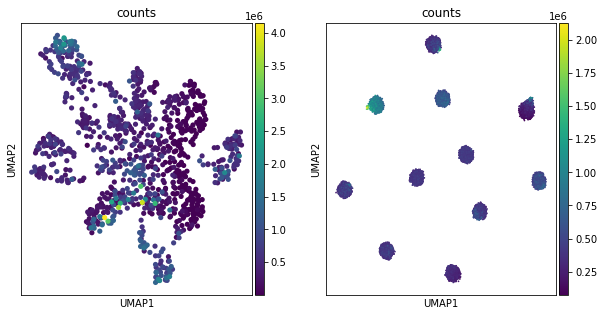

In [27]:
fig, axes = plt.subplots(ncols=2, figsize=(10,5))
sc.pl.umap(data, color='counts', ax=axes[0], show=False)
sc.pl.umap(sim_data, color='counts', ax=axes[1], show=False)

<AxesSubplot:ylabel='counts'>

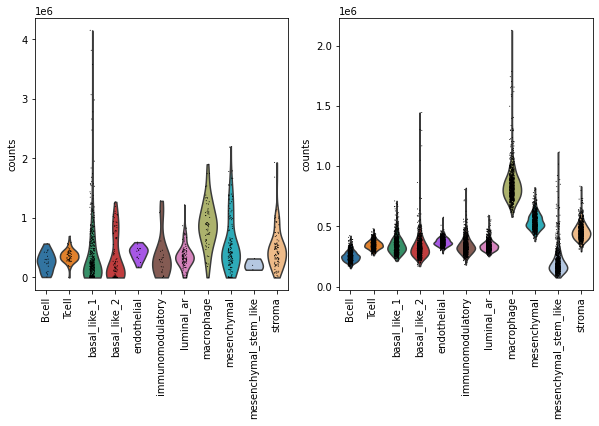

In [28]:
fig, axes = plt.subplots(ncols=2, figsize=(10,5))
sc.pl.violin(data, ['counts'], groupby='cell_type', ax=axes[0], show=False, rotation=90, log=False)
sc.pl.violin(sim_data, ['counts'], groupby='cell_type', ax=axes[1], show=False, rotation=90, log=False)

## Observations:
    * Data looks pretty similar between simulated & real
    * Was able to get sparsity similar between simulated & real
    * Inter-celltype variability also appears much less in the real cell type compared with the simulated, 
        atleast based on the UMAPs

## Taking two example cell type & placing on grid

In [29]:
print("Available cell types", label_set)
cts = ['Bcell', 'Tcell', 'luminal_ar', 'mesenchymal', 'stroma']
print("\nSelected cell types: ", cts)

Available cell types ['Bcell' 'Tcell' 'basal_like_1' 'basal_like_2' 'endothelial'
 'immunomodulatory' 'luminal_ar' 'macrophage' 'mesenchymal'
 'mesenchymal_stem_like' 'stroma']

Selected cell types:  ['Bcell', 'Tcell', 'luminal_ar', 'mesenchymal', 'stroma']


In [30]:
ct_props = [sum(labels==ct)/len(labels) for ct in cts]
ct_props = np.array(ct_props)/sum(ct_props)
n_spots = 2000
dim = int(np.sqrt(n_spots))
n_spots = dim**2

coords = np.zeros((n_spots, 2), dtype=int)
x, y = 0, 0
for i in range(coords.shape[0]):
    coords[i,:] = x, y
    y += 1
    if y==dim-1:
        x += 1
        y = 0

In [31]:
n_hoods = int(np.sqrt(data.shape[0])*2)
print("Number of neighbourhoods:", n_hoods)
kmeans = KMeans(n_clusters=n_hoods)
hoods = kmeans.fit_predict(coords)
hood_set = np.unique(hoods)

Number of neighbourhoods: 66


In [34]:
hood_centres = np.zeros((len(hood_set), 2))
for i, hood in enumerate(hood_set):
    hood_bool = hoods==hood
    hood_coords = coords[hood_bool,:].mean(axis=0)
    hood_centres[i,:] = hood_coords

In [71]:
### For each hood, getting the neighbouring hoods, so can prevent certain hood types 
### from appearing next to eachother for the purpose of the simulation.
point_tree = spatial.cKDTree(hood_centres)
neighbours = []
distance=9
for i, hood in enumerate(hood_set):
    n_index = point_tree.query_ball_point(hood_centres[i,:], distance)
    n_index = np.array(n_index, dtype=np.int_)
    neighbours.append(n_index[n_index != i])
print(np.median([len(neighs) for neighs in neighbours]))
print(neighbours)

6.0
[array([56, 48, 38, 33, 18, 53, 45]), array([61, 20, 15,  6, 50,  8]), array([21, 57, 32, 47, 44, 63, 29]), array([16, 52, 64, 24, 42, 28, 34]), array([ 7, 59, 45, 26, 40, 19, 55]), array([27, 36, 32, 29, 37]), array([31, 62, 41,  1, 58, 20, 15]), array([53, 23, 30, 59, 45,  4]), array([61,  1, 50, 25, 21, 36, 57]), array([16, 54, 43]), array([52, 48, 24, 33, 65, 60, 46]), array([39, 30, 59, 26]), array([35, 34, 62, 41]), array([16, 56, 43, 38]), array([35, 31, 58]), array([31,  1, 58,  6, 51, 50]), array([54,  3, 48, 24,  9, 43, 38, 42, 13]), array([51, 50, 27, 36]), array([56,  0, 53, 23]), array([59,  4, 26, 49, 55, 47, 44]), array([28, 62, 61, 41, 60,  1, 46,  6]), array([22, 25,  8, 57,  2, 47]), array([40, 55, 65, 25, 21, 47]), array([18, 53, 30,  7]), array([16, 10, 54, 52,  3, 48, 38, 42]), array([22, 65, 61, 46,  8, 21]), array([11, 59,  4, 19, 49]), array([36, 17, 32,  5]), array([52,  3, 64, 34, 62, 60, 20]), array([32,  2,  5, 63, 37]), array([11, 39, 23,  7, 59]), arra

In [72]:
## For each neighbourhood, determine the hood types, preventing certain types from appearing next to each other ##
hood_type_defs = {'immune': [.5, .5, 0, 0, 0], # cell type proportions, Bcell, Tcell, luminal_ar, mesenchymal
              'stroma': [0]*4+[1], #just stroma
              'cancer': [0, 0, .5, .5, 0], #luminal_ar & mesenchymal
             }
prevent_neighbouring = {'stroma': 'cancer', 'cancer': 'stroma',
                       'immune': ''} #Prevents hood types from being neighbours
hood_type_set = list(hood_type_defs.keys())
hood_types = np.array(['              ']*len(hoods))
for i, hood in enumerate(hood_set):
    hood_neighbours = neighbours[i]
    hood_type = np.random.choice(hood_type_set, 1)[0]
    while np.any([hood_types[neighi]==prevent_neighbouring[hood_type] for neighi in hood_neighbours]):
        hood_type = np.random.choice(hood_type_set, 1)[0]
    hood_types[i] = hood_type

hood_type_labels = np.array([hood_types[np.where(hood_set==hood_label)[0][0]] 
                             for hood_label in hoods])

In [73]:
#rand_std = np.mean(hood_type_defs['random'])
std = .1
rand_std = std
hood_props = []
for i, hood in enumerate(hood_set):
    #init_props = [ct_props[i]+np.random.normal(0, std) for i in range(len(ct_props))]
    std_i = rand_std if hood_types[i]=='random' else std
    hood_type_props = hood_type_defs[ hood_types[i] ]
    init_props = [hood_type_props[i]+np.random.normal(0, std_i) if hood_type_props[i]>0 else 0 for i in range(len(hood_type_props))]
    nonneg = [ct_prop if ct_prop>0 else 0 for ct_prop in init_props]
    hood_prop = np.array([ct_prop/sum(nonneg) for ct_prop in nonneg])
    hood_props.append(hood_prop)

In [74]:
spatial_counts = np.zeros((n_spots, sim_counts.shape[1]))
ct_indexes = [np.where(sim_labels==ct)[0] for ct in cts]
tot_cells = 20
spot_cell_counts = [0]*n_spots
spot_ct_props = np.zeros((n_spots, len(cts)))
for i, hood in enumerate(hood_set):
    hood_prop = hood_props[i]
    hood_ct_counts = np.round(hood_prop*tot_cells).astype(int)
    hood_indices = np.where(hoods==hood)[0]
    for spot_j in hood_indices:
        spot_cell_indices = []
        spot_cell_indexes = []
        for ct_i in range(len(cts)):
            cell_indices = np.random.choice(ct_indexes[ct_i], hood_ct_counts[ct_i], replace=False)
            spot_cell_indices.extend(cell_indices)
            spot_cell_indexes.append(cell_indices)
        for ct_i in range(len(cts)):
            spot_ct_props[spot_j,ct_i] = len(spot_cell_indexes[ct_i])/len(spot_cell_indices) 
             
        spot_cell_counts[spot_j] = len(spot_cell_indices)
            
        spatial_counts[spot_j,:] = sim_data.raw.X[spot_cell_indices,:].sum(axis=0)
        
spot_ct_props = pd.DataFrame(spot_ct_props, columns=cts)

In [75]:
print(sim_data.shape)
print(spatial_counts.shape)

(9999, 10335)
(1936, 10335)


## Creating Spatial AnnData

In [80]:
spatial_data = sc.AnnData(pd.DataFrame(spatial_counts, columns=sim_data.var_names))
spatial_data.obs['hood'] = hoods
spatial_data.obs['hood'] = spatial_data.obs['hood'].astype('category')
spatial_data.obs['hood_type'] = hood_type_labels
spatial_data.obs['hood_type'] = spatial_data.obs['hood_type'].astype('category')
spatial_data.obs['cell_counts'] = spot_cell_counts
spatial_data.obsm['spatial'] = coords
spot_ct_props.index = spatial_data.obs_names
spatial_data.obsm['deconvolution'] = spot_ct_props
for i in range(len(cts)):
    spatial_data.obs[cts[i]] = spot_ct_props.values[:,i]

In [81]:
### Adding image information ###
spatial_data.obs["imagecol"] = spatial_data.obsm['spatial'][:,0]
spatial_data.obs["imagerow"] = spatial_data.obsm['spatial'][:,1]
# Create image
quality = 'hires'
max_size = np.max([spatial_data.obs["imagecol"].max(),spatial_data.obs["imagerow"].max()])
max_size = int(max_size + 0.1*max_size)

image = Image.new('RGB', (max_size, max_size), (255, 255, 255)) # white color
imgarr = np.array(image)

library_id = "spatial"

# Adding image to anndata #
spatial_data.uns["spatial"] = {}
spatial_data.uns["spatial"][library_id] = {}
spatial_data.uns["spatial"][library_id]["images"] = {}
spatial_data.uns["spatial"][library_id]["images"][quality] = imgarr
spatial_data.uns["spatial"][library_id]["use_quality"] = quality
spatial_data.uns["spatial"][library_id]["scalefactors"] = {}
spatial_data.uns["spatial"][library_id]["scalefactors"]\
                                           ["tissue_" + quality + "_scalef"] = 1
spatial_data.uns["spatial"][library_id]['scalefactors']['spot_diameter_fullres'] = 1

In [82]:
spatial_data.raw = spatial_data
sc.pp.normalize_total(spatial_data)
sc.pp.log1p(spatial_data)
sc.tl.pca(spatial_data)

In [83]:
#### Now running through standard scanpy to see clustering results... ####
sc.pp.neighbors(spatial_data)
sc.tl.umap(spatial_data)

In [84]:
sc.tl.leiden(spatial_data, resolution=1)

In [85]:
k = len(hood_type_set)
kmeans = KMeans(n_clusters=k)
kclusters = kmeans.fit_predict(spatial_data.X)
spatial_data.obs[f'{k}clusters'] = kclusters
spatial_data.obs[f'{k}clusters'] = spatial_data.obs[f'{k}clusters'].astype('category')

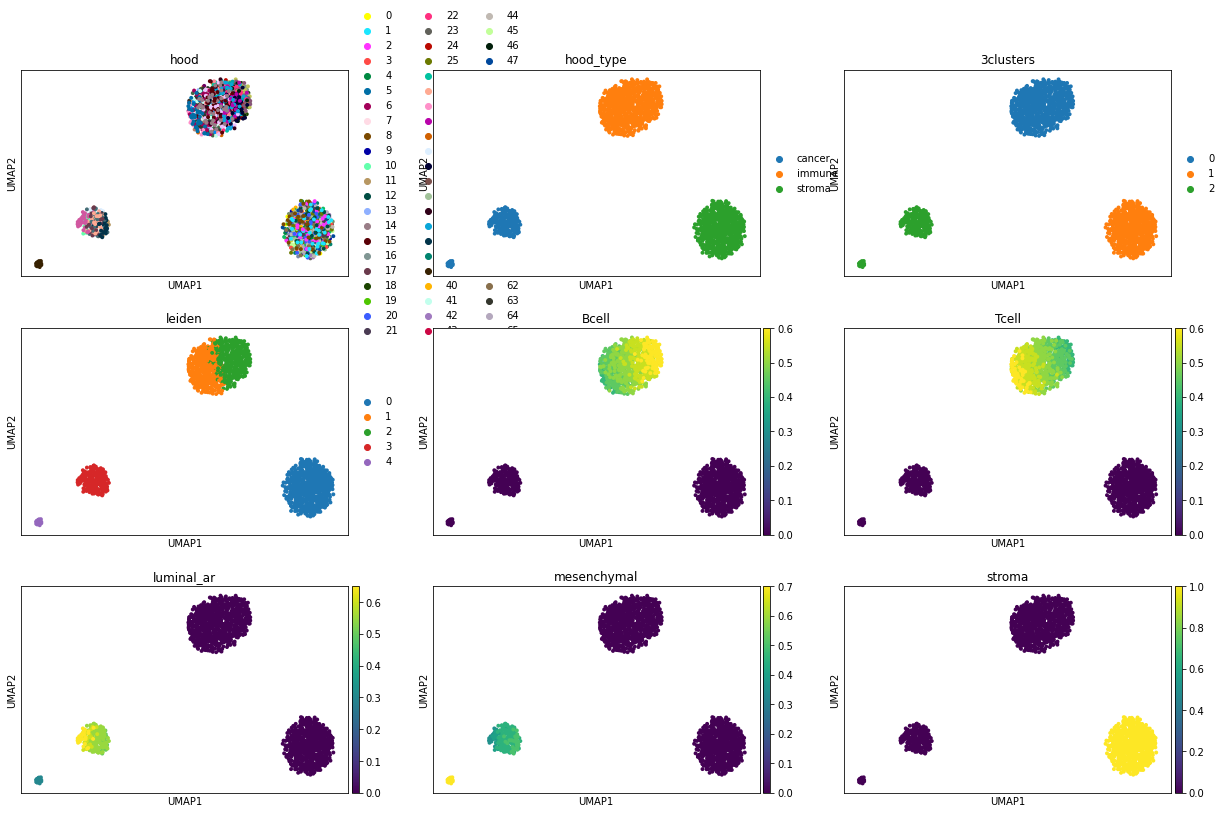

In [86]:
sc.pl.umap(spatial_data, color=['hood', 'hood_type', f'{k}clusters', 
                                'leiden']+cts, ncols=3)

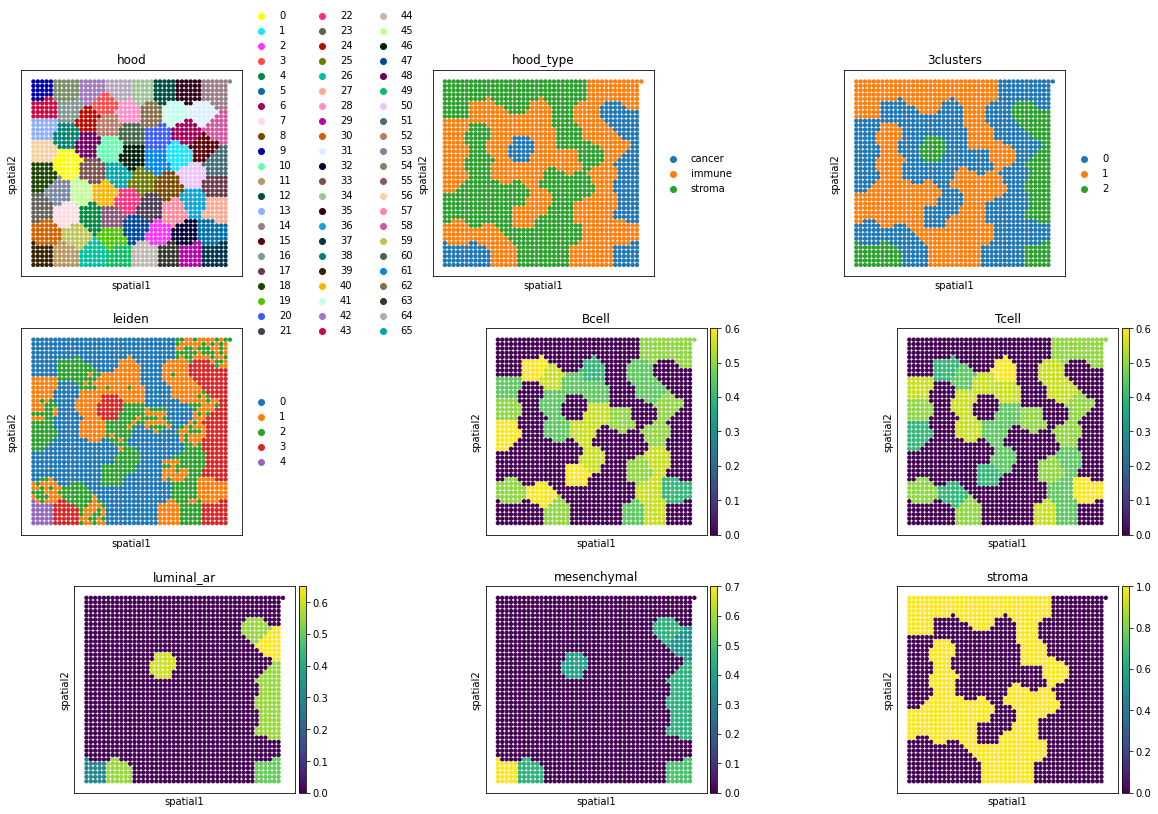

In [87]:
sc.pl.spatial(spatial_data, color=['hood', 'hood_type', f'{k}clusters', 'leiden']+cts, ncols=3)

In [90]:
##### Saving the results ######
spatial_data.write_h5ad(out_dir+'spatialsim_v2.h5ad', compression='gzip')